![logo](./img/LogoLine_horizon_C3S.png)

# Visualising Lake Surface Water Temperature (LSWT) as timeseries at one location on a given lake and the spatial distribution of the LSWT for a given day

<font color='red'>Before continuing with this tutorial, please verify that the C3S API is installed. All the information about this api is available at: </font>

https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key


****

In this tutorial we will access lake surface water temperature data from the Climate Data Store (CDS) and plot
- the timeseries at the lake centre for a given day of the year and 
- the LSWT, uncertainty and quality level for all the pixels on the given lake on a selected day. 

The tutorial comprises two main steps:

1. Dowload and decompress data for every year on record on the selected day of the year
2. Visualise and save the lake surface water temperature **timeseries** (displaying quality levels and uncertainty) **at the lake centre**, but other locations can be given through their lat/lon coordinates
3. Visualise the location of the lake centre (or of the preferred location) on the lake mask
4. Plot the **LSWT, uncertainty and quality level for all the available pixels** on the selected lake **on a given date**

This tutorial will show you that:
1. how to find out for which lakes LSWT is available
2. the lake mask of a specific lake tells in which pixels to expect LSWT for a given lake
3. LSWT files contains LSWT but also quality levels, uncertainty and the lake mask
4. LSWTs have to be used together with the quality levels and the uncertainy. We recommend to use LSWT of quality level 4 and 5 only.
5. not all the pixels belonging to a lake will have LSWT for a given time


## Import librairies


The lake surface water temperature data will be download in a zip file containing a NetCDF file. We need libraries to download data from the CDS but also libraires to manage zip files (zipfile library) and  NetCDF files (xarray library). We also use libraries to plot and visualise data (matplotlib and cartopy libraries).

Additional libraires: os and glob are used for file management 

In [1]:
import cdsapi
import os
import glob
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
import numpy as np
import pandas as pd


For downloading and generating the timeserie, three inputs are required:

- The name of the lake (lake_name). The name of the lake must exists in the list of available lakes.
- The output directory name (output_dir) where the different files will be saved.
- The .csv file with the lake list of the GloboLakes 1000 lakes. 
- The day of the year given as day and month

In [2]:
# Version of LSWT: currently available v4.0 (GloboLakes lakes). Soon available v4.5 (ESA CCI LAKES lakes)
version = '4.0'

# Input the name of the lake
lake_name = 'Titicaca'

# The directory to store downloaded files
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

# The output directory name 
output_dir = DATADIR 
os.makedirs(output_dir, exist_ok=True)

# Day and month 
mm, dd = '07', '01'

Current version of the Lake Surface Water Temperature dataset on CDS (LSWT v4.0 + LSWT v4.2) contains 1000 lakes.
The lake list (LAKELIST-1000lakes-GloboLakes-CENTRE-LSWT-v4.0-fv01.0.csv) can be downloaded via the lake website at the University of Reading http://www.laketemp.net/home_GL/GLTargets.php. Here we read directly the file from the laketemp website.
A new version LSWT v4.5 will be available soon and it will contain 2000 lakes. If you are using LSWT v4.5, the lake list (ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv) can be downloaded via the lake website at the University of Reading http://www.laketemp.net/home_CCI/cci_targets.php. Here we read directly the file from the laketemp website.

In [36]:
# Read the file containing Name, Country, ID, lat/lon of the lake centre, maximum distance to land and 
# the lat/lon of a box surrounding the lake for all the 1000 GloboLakes lakes / 2024 ESA CCI LAKES lakes
if version == '4.0':
    lakes_df = pd.read_csv(
        'http://www.laketemp.net/home_GL/LAKELIST-1000lakes-GloboLakes-CENTRE-LSWT-v4.0-fv01.0.csv'
    )
elif version == '4.5':
    lakes_df = pd.read_csv(
        'http://www.laketemp.net/home_CCI/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv'
    )

# Extract the lis of available lakes
available_lakes = lakes_df.iloc[:, 1]

# Find the position of the lake in the csv list which we have read in a pandas dataframe
idx = [i for i in range(len(lakes_df.iloc[:, 1])) if lake_name in lakes_df.iloc[i, 1]]

if len(idx) == 0 :
    # Verify that the lake surface water temperature is available for the selected lake.
    # If the lake is not available it may be because of a spelling mistake.
    print (f'The lake "{lake_name}" is not available')
elif len(idx)>1:
    # If more than one lake is found, instruct user to be more specific in selection:
    print('Manually check the lake name!')
    print(lakes_df.iloc[idx])
else:
    lake_row = lakes_df.iloc[idx[0]]
    # # Extract the lat/lon of the centre
    latcentre, loncentre = lake_row[' lat centre'], lake_row[' lon centre']
    latmin,    latmax    = lake_row[' lat min'], lake_row[' lat max']
    lonmin,    lonmax    = lake_row[' lon min'], lake_row[' lon max']
    # latmin,    latmax    = df.iloc[idx, 6].iloc[0], df.iloc[idx, 7].iloc[0]
    # lonmin,    lonmax    = df.iloc[idx, 8].iloc[0], df.iloc[idx, 9].iloc[0]
lake_row

GLWD                                 20
 Name                     lago Titicaca
 Country                           Peru
 lat centre                    -15.7681
 lon centre                    -69.4569
 max distance to land              23.4
 lat min                       -16.5931
 lat max                       -15.2375
 lon min                       -70.0153
 lon max                       -68.5764
Name: 17, dtype: object

## Downloading the data

Having the CDS api, this function will retrive the  data for the selected lake into the defined output directory. The downloaded file is compressed (zip format) containing the data file in NetCDF format. For reading the lake surface water temeparture data, the files will be extracted in the output directory. 

In [4]:
# Setting the years for the time series
if version == '4.0':
    years = (np.arange(1995,2020).astype(str)).tolist()
elif version == '4.5':
    years = (np.arange(1995,2023).astype(str)).tolist() 

In [5]:
download_zip_file = os.path.join(DATADIR, f'{lake_name}.zip')
if not os.path.isfile(download_zip_file):
    c = cdsapi.Client()
    c.retrieve(
        'satellite-lake-water-temperature',
        {
            'version': version,
            'variable': 'lake_surface_water_temperature',
            'year': years,
            'month': mm,
            'day': dd,
            'format': 'zip' # valid formats: zip, tar and tgz
        },
        download_zip_file
    )

with zipfile.ZipFile(download_zip_file) as z:
    filelist = [os.path.join(DATADIR, f) for f in z.namelist()]
    z.extractall(DATADIR)
# Ensure the filelist is in the correct order:
filelist = sorted(filelist)

2023-04-17 11:03:35,495 INFO Welcome to the CDS
2023-04-17 11:03:35,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-lake-water-temperature
2023-04-17 11:03:35,653 INFO Request is queued
2023-04-17 11:03:36,711 INFO Request is running
2023-04-17 11:04:08,218 INFO Request is completed
2023-04-17 11:04:08,219 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data2/dataset-satellite-lake-water-temperature-766deb62-0bbe-4681-a7e5-e4407d94a56b.zip to ./data_dir/Titicaca.zip (382.1M)
2023-04-17 11:05:21,241 INFO Download rate 5.2M/s  


## Visualise the Lake Surface Water Temperature timeseries

Now that the data have been extracted, we can read and plot them. To read the data in NetCDF format we use the Xarray library and for the visualisation of the time series we use Matplotlib.

The LSWT are plotted per quality level (color of the dot) and an error bar show the LSWT uncertainty for each value.

The figure with the timeseries will be saved in the output directory in png format in the [lake_name]_timeseries.png file

In [43]:
# Read all files (this uses dask so the data is not loaded into RAM)
ds = xr.open_mfdataset(filelist)
ds_last = ds.isel(time=-1)

# Select a point, and load into RAM to allow faster further calculations
ds_point = ds.sel(
    lat=latcentre, lon=loncentre,
    method="nearest"
).squeeze().compute()  # The .compute() loads the reduced data array into RAM
ds_point

<xarray.Dataset>
Dimensions:                         (time: 24)
Coordinates:
    lat                             float32 -15.77
    lon                             float32 -69.47
  * time                            (time) datetime64[ns] 1995-07-01T12:00:00...
Data variables:
    lake_surface_water_temperature  (time) float32 nan nan nan ... 284.8 286.1
    lswt_uncertainty                (time) float32 nan nan nan ... 0.207 0.159
    quality_level                   (time) float32 nan nan nan ... 3.0 5.0 5.0
    obs_instr                       (time) float32 nan nan nan ... 16.0 32.0
    flag_bias_correction            (time) float32 nan nan nan ... nan nan nan
    lakeid                          (time) float64 20.0 20.0 20.0 ... 20.0 20.0
Attributes: (12/50)
    title:                           NERC GloboLakes Lake Surface Water Tempe...
    summary:                         L3S product from the NERC GloboLakes pro...
    citation:                        Carrea, L.; Merchant, C.J. (2019): Globo...
    license:                         Creative Commons by Attribution ShareAli...
    reference:                       http://www.globolakes.ac.uk/ http://www....
    institution:                     NERC
    ...                              ...
    southernmost_latitude:           -90.0
    easternmost_longitude:           180.0
    westernmost_longitude:           -180.0
    processing_level:                L3S
    cdm_data_type:                   grid
    source_file:                     19950701120000-ESACCI-L3C_GHRSST-ATSR2-C...

In [44]:
# Convert to a pandas dataframe for plotting:
df_point = ds_point.to_pandas()
# Remove any point without a lswt value
df_point = df_point[~np.isnan(df_point['lake_surface_water_temperature'].values)]
df_point["lake_surface_water_temperature"] -= 273.15
df_point

,lat,lon,lake_surface_water_temperature,lswt_uncertainty,quality_level,obs_instr,flag_bias_correction,lakeid
time,,,,,,,,
1999-07-01 12:00:00,-15.775,-69.474998,10.519989,0.173,4.0,1.0,1.0,20.0
2003-07-01 12:00:00,-15.775,-69.474998,12.170013,0.142,4.0,4.0,2.0,20.0
2007-07-01 12:00:00,-15.775,-69.474998,12.359985,0.200,5.0,16.0,NaN,20.0
2008-07-01 12:00:00,-15.775,-69.474998,12.720001,0.315,2.0,16.0,NaN,20.0
2009-07-01 12:00:00,-15.775,-69.474998,12.329987,0.179,5.0,8.0,2.0,20.0
2010-07-01 12:00:00,-15.775,-69.474998,13.220001,0.289,2.0,16.0,NaN,20.0
2012-07-01 12:00:00,-15.775,-69.474998,12.260010,0.184,5.0,16.0,NaN,20.0
2014-07-01 12:00:00,-15.775,-69.474998,12.779999,0.143,5.0,16.0,NaN,20.0
2015-07-01 12:00:00,-15.775,-69.474998,8.839996,0.260,2.0,16.0,NaN,20.0


In [45]:
# We create a plotting function that we can re-use in this section:
def plot_time_series(
    df_point, lake_name, output_dir,
    quality_flags=[1,2,3,4,5,6],
    qf_colors = ['darkgrey','purple','green','cyan','red'],
    plotname_tag = ""
):
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    qf_mask = [qf in quality_flags for qf in df_point["quality_level"]]
    df_point = df_point[qf_mask]
    df_point["lake_surface_water_temperature"].plot(
        ax=ax, linestyle='-', color='grey', lw=0.5,
        label='_nolegend_',
        yerr = df_point["lswt_uncertainty"], capthick=1.9, capsize=2, ecolor="black", mew=1,
    )
    
    # Plot the quality flags over the top
    for qf in quality_flags:
        if qf not in df_point["quality_level"].values:
            continue
        df_qf = df_point[df_point["quality_level"]==qf]
        plt.scatter(
            df_qf.index, df_qf["lake_surface_water_temperature"],
            marker='o', color=qf_colors[qf-1], alpha=0.7,
            label = f"Quality level = {qf}"
        )

    plt.legend(loc='upper left')

    plt.xlim("1994","2020")
    plt.title(f'Lake: {lake_name.title()} at lake centre')
    plt.xlabel("Year")
    plt.ylabel("Lake surface water temperature (°C)")
    # save the figure
    png_file = f'{output_dir}/{lake_name}_timeseries{plotname_tag}.png'
    plt.savefig(png_file, dpi=500)

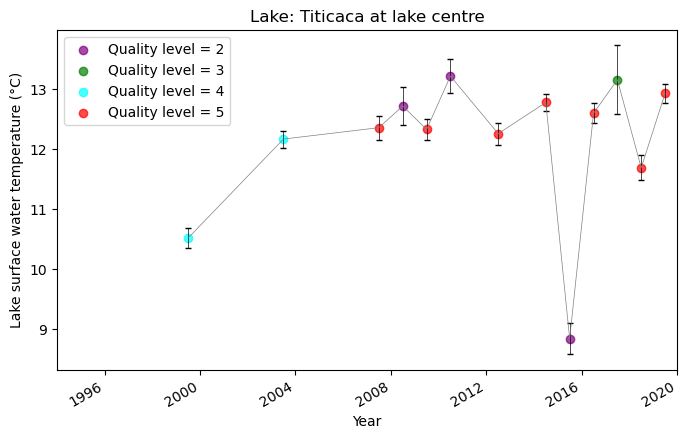

In [46]:
plot_time_series(
    df_point, lake_name, output_dir,
)

We recommend to use **ONLY LSWT of best quality level 4 and 5**. **LSWT of quality level 1 should never be used**. If you want to use lower quality level data, careful checks have to be carried out. We plot then only the observations of quality level 4 and 5.

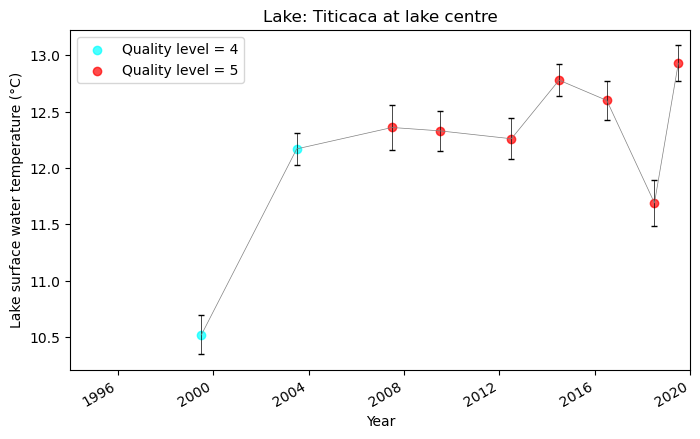

In [47]:
plot_time_series(
    df_point, lake_name, output_dir,
    quality_flags=[4,5], plotname_tag = "_ql45"
)

## Plot the position of the location of the extracted LSWT on the lake mask 
 
For generating this figure we use the cartopy library. The lake mask showing the cells belonging to the selected lake is plotted and the position on the lake where the time series was extracted is highlighted.

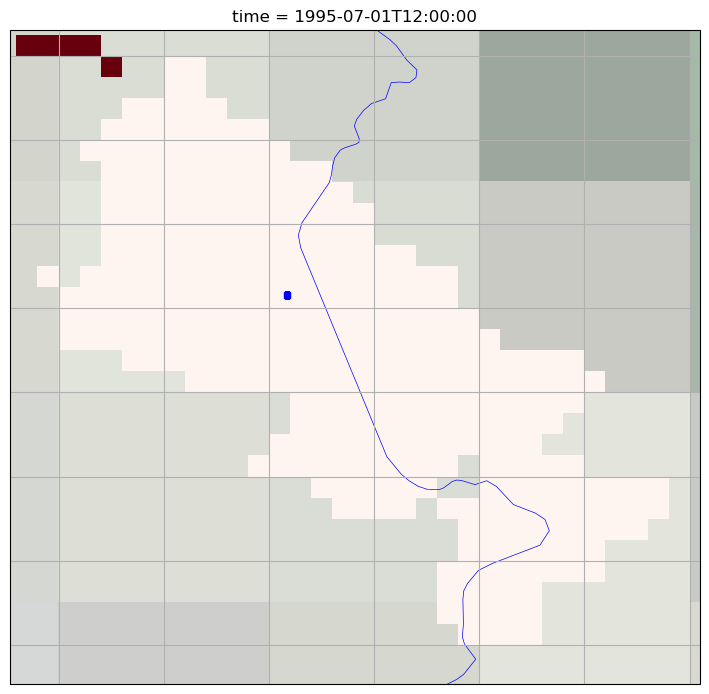

In [42]:
# Set a margin to slighlty enlarge the figure
step = 0.1

# We take teh lakeid from the last timestep and cut out to our area of interest
lakeid = ds_last.lakeid.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

# Plot the lake mask and the location of the centre
fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.gridlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
# Set the extent using the fields extracted from the Lakes metadata earlier
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lakeid.plot(
    cmap=plt.cm.Reds,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj},
    add_colorbar=False
)

# Plot the location of the lake centre where the LSWT time series have been extracted
plt.scatter(x = [loncentre], y = [latcentre], s = 20, marker='s', color = 'blue', transform = crs.PlateCarree())

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries_location.png'
plt.savefig(png_file, dpi=500)

## Plot the LSWT, quality level and uncertainty for the selected day of the last year on record
 
 For generating this figure we use the cartopy library.
 
 First we plot the LSWT over the full lake for the selected day and month and for the last year in the time      series.

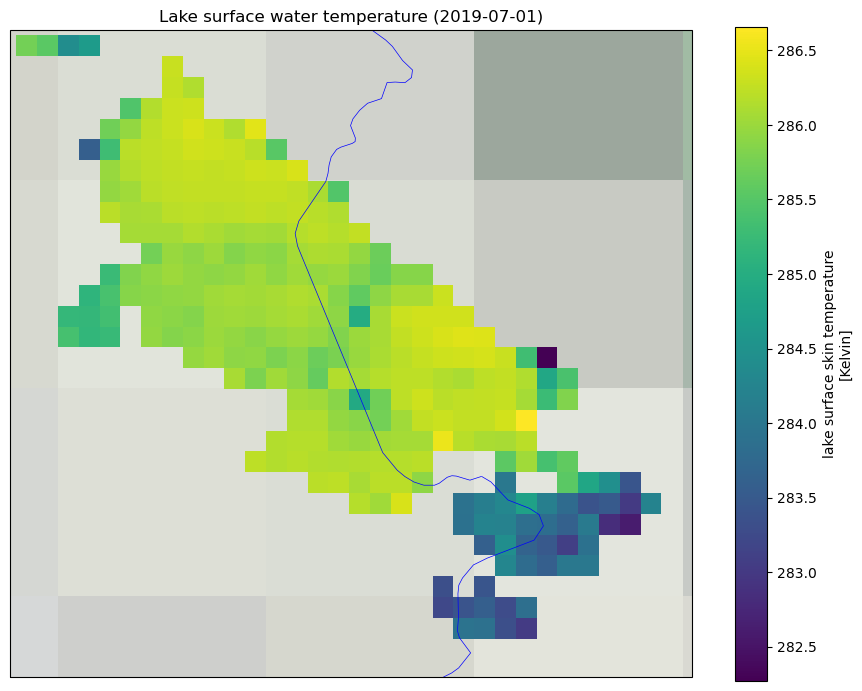

In [60]:
lswt_y = ds_last.lake_surface_water_temperature.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))
datestr = str(lswt_y.time.values)[:10]

fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(
    cmap=plt.cm.viridis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj},
)
ax.set_title(f"Lake surface water temperature ({datestr})")


# save the figure
png_file = f'{output_dir}/{lake_name}_LSWT_{datestr}.png'
plt.savefig(png_file, dpi=500)

Now we plot the LSWT uncertainty for the selected day and month and for the last year in the time series.

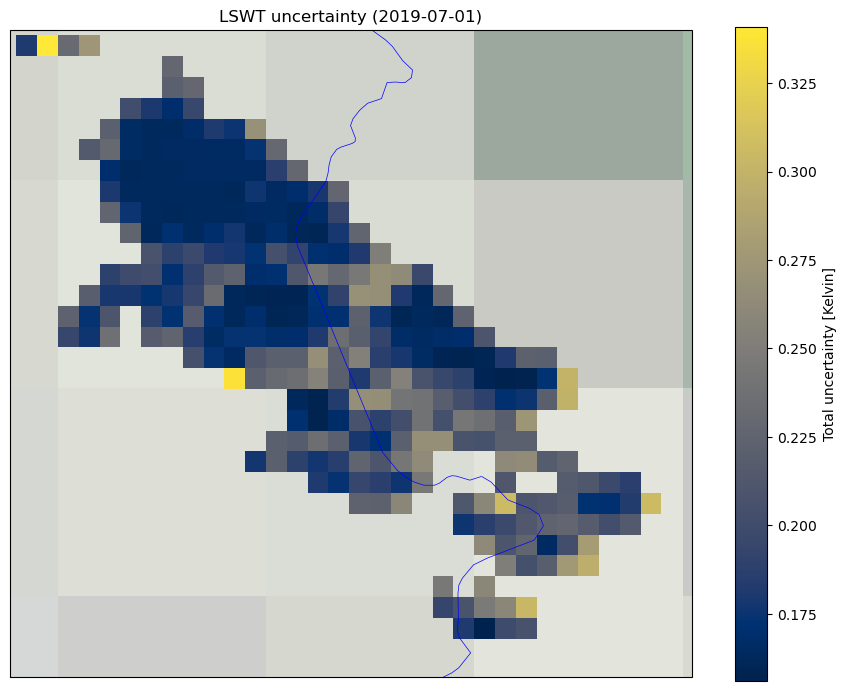

In [62]:
lswt_y = ds_last.lswt_uncertainty.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(cmap=plt.cm.cividis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj})

ax.set_title(f"LSWT uncertainty ({datestr})")


# save the figure
png_file = f'{output_dir}/{lake_name}_LSWT_UNC_{datestr}.png'
plt.savefig(png_file, dpi=500)

Now we plot the quality levels for the selected day and month and for the last year in the time series.

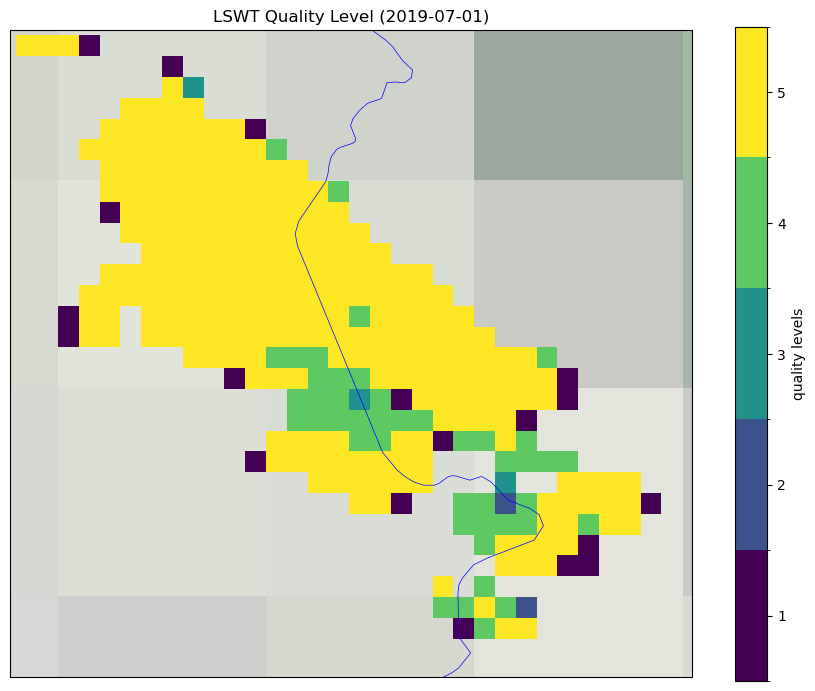

In [64]:
lswt_y = ds_last.quality_level.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(
    cmap=plt.cm.viridis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj},
    levels=[0.5,1.5,2.5,3.5,4.5,5.5], cbar_kwargs={'ticks': [1,2,3,4,5]}
)
ax.set_title(f"LSWT Quality Level ({datestr})")


# save the figure
png_file = f'{output_dir}/{lake_name}_QL_{datestr}.png'
plt.savefig(png_file, dpi=500)